# Interactive Diamond Detection
This notebook provides real-time parameter tuning for diamond detection in images. Use the interactive widgets below to adjust various parameters and see immediate feedback on detection results.

In [1]:
# Import Required Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import os

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Define Utility Functions
def angle_between_points(p1, p2, p3):
    """Calculate angle between three points"""
    v1 = p1 - p2
    v2 = p3 - p2
    dot = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    if norm_v1 == 0 or norm_v2 == 0:
        return 0
    cos_theta = dot / (norm_v1 * norm_v2)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    angle = np.arccos(cos_theta) * 180 / np.pi
    return angle

def display_image(image, title="Image", cmap='gray'):
    """Display image using matplotlib"""
    plt.figure(figsize=(10, 8))
    if len(image.shape) == 3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

Loaded image: page_3.png - Shape: (7200, 10800, 3)


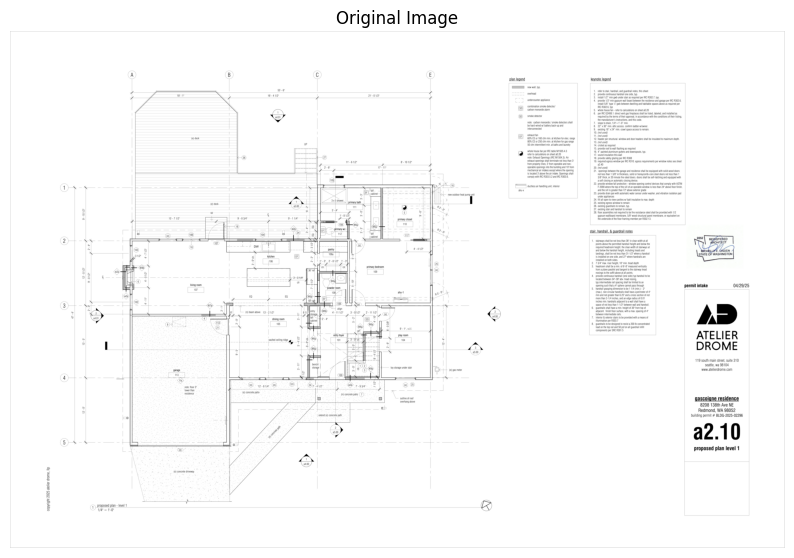

In [3]:
# Load and Display Source Image
image_path = "page_3.png"
if os.path.exists(image_path):
    source_image = cv2.imread(image_path)
    print(f"Loaded image: {image_path} - Shape: {source_image.shape}")
    display_image(source_image, "Original Image")
else:
    print(f"Image {image_path} not found. Please ensure the image is in the current directory.")
    source_image = None

In [4]:
# Build Diamond Detection Function
def detect_diamonds(source_image, 
                   blur_kernel=5, 
                   canny_low=50, 
                   canny_high=150, 
                   epsilon_factor=0.02,
                   min_width=80, 
                   max_width=110, 
                   min_height=80, 
                   max_height=110, 
                   size_tolerance=10,
                   min_area=3000, 
                   max_area=6000,
                   min_angle=80, 
                   max_angle=100,
                   show_intermediate=False):
    """
    Detect diamonds in the image with configurable parameters
    """
    if source_image is None:
        return None, 0, {}
    
    # Create a copy to work with
    result_image = source_image.copy()
    gray = cv2.cvtColor(source_image, cv2.COLOR_BGR2GRAY)
    
    # Step 2: Gaussian blur
    blurred = cv2.GaussianBlur(gray, (blur_kernel, blur_kernel), 0)
    
    # Step 3: Canny edge detection
    edges = cv2.Canny(blurred, canny_low, canny_high)
    
    # Step 4: Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Step 5: Find quadrilaterals
    quads = []
    for cnt in contours:
        epsilon = epsilon_factor * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        if len(approx) == 4:
            quads.append((cnt, approx))
    
    # Step 6: Filter by size
    size_filtered = []
    for cnt, approx in quads:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        if (min_width < w < max_width and 
            min_height < h < max_height and 
            abs(w - h) < size_tolerance and 
            min_area < area < max_area):
            size_filtered.append((cnt, approx))
    
    # Step 7: Filter by angles
    diamonds = []
    for cnt, approx in size_filtered:
        if len(approx) == 4:
            angles = []
            for i in range(4):
                p1 = approx[i][0]
                p2 = approx[(i + 1) % 4][0]
                p3 = approx[(i + 2) % 4][0]
                angle = angle_between_points(p1, p2, p3)
                angles.append(angle)
            if all(min_angle < a < max_angle for a in angles):
                diamonds.append(cnt)
    
    # Step 8: Draw detected diamonds
    for diamond in diamonds:
        cv2.drawContours(result_image, [diamond], 0, (0, 255, 0), 2)
    
    # Prepare debug info
    debug_info = {
        'total_contours': len(contours),
        'quadrilaterals': len(quads),
        'size_filtered': len(size_filtered),
        'diamonds_detected': len(diamonds)
    }
    
    return result_image, len(diamonds), debug_info

In [5]:
# Create Interactive Parameter Controls
def create_interactive_detection():
    """Create interactive widgets for real-time parameter tuning"""
    
    # Output widget for displaying results
    output = widgets.Output()
    
    def update_detection(**kwargs):
        with output:
            clear_output(wait=True)
            
            if source_image is not None:
                result_image, diamond_count, debug_info = detect_diamonds(source_image, **kwargs)
                
                # Create subplot layout
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
                
                # Display original image
                ax1.imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB))
                ax1.set_title("Original Image")
                ax1.axis('off')
                
                # Display result with detections
                ax2.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
                ax2.set_title(f"Detected Diamonds: {diamond_count}")
                ax2.axis('off')
                
                plt.tight_layout()
                plt.show()
                
                # Display debug information
                print("\\n=== Detection Statistics ===")
                print(f"Total contours found: {debug_info['total_contours']}")
                print(f"Quadrilaterals found: {debug_info['quadrilaterals']}")
                print(f"After size filtering: {debug_info['size_filtered']}")
                print(f"Final diamonds detected: {debug_info['diamonds_detected']}")
                
                # Save the result
                cv2.imwrite("detected_diamonds.png", result_image)
                print("\\nResult saved as: detected_diamonds.png")
            else:
                print("No source image loaded!")
    
    # Create parameter widgets
    blur_slider = widgets.IntSlider(value=5, min=1, max=15, step=2, description='Blur Kernel:')
    canny_low_slider = widgets.IntSlider(value=50, min=10, max=200, step=10, description='Canny Low:')
    canny_high_slider = widgets.IntSlider(value=150, min=50, max=300, step=10, description='Canny High:')
    epsilon_slider = widgets.FloatSlider(value=0.02, min=0.005, max=0.05, step=0.005, description='Epsilon:')
    
    min_width_slider = widgets.IntSlider(value=80, min=20, max=150, step=5, description='Min Width:')
    max_width_slider = widgets.IntSlider(value=110, min=80, max=200, step=5, description='Max Width:')
    min_height_slider = widgets.IntSlider(value=80, min=20, max=150, step=5, description='Min Height:')
    max_height_slider = widgets.IntSlider(value=110, min=80, max=200, step=5, description='Max Height:')
    size_tolerance_slider = widgets.IntSlider(value=10, min=1, max=30, step=1, description='Size Tolerance:')
    
    min_area_slider = widgets.IntSlider(value=3000, min=1000, max=8000, step=200, description='Min Area:')
    max_area_slider = widgets.IntSlider(value=6000, min=3000, max=10000, step=200, description='Max Area:')
    
    min_angle_slider = widgets.IntSlider(value=80, min=60, max=90, step=2, description='Min Angle:')
    max_angle_slider = widgets.IntSlider(value=100, min=90, max=120, step=2, description='Max Angle:')
    
    # Use interactive widget
    interactive_plot = widgets.interactive(update_detection,
                                         blur_kernel=blur_slider,
                                         canny_low=canny_low_slider,
                                         canny_high=canny_high_slider,
                                         epsilon_factor=epsilon_slider,
                                         min_width=min_width_slider,
                                         max_width=max_width_slider,
                                         min_height=min_height_slider,
                                         max_height=max_height_slider,
                                         size_tolerance=size_tolerance_slider,
                                         min_area=min_area_slider,
                                         max_area=max_area_slider,
                                         min_angle=min_angle_slider,
                                         max_angle=max_angle_slider)
    
    return interactive_plot, output

In [6]:
# Create Interactive Widget Interface
print("Setting up interactive diamond detection interface...")
print("Adjust the parameters below to see real-time updates!")

interactive_plot, output = create_interactive_detection()
display(interactive_plot)

Setting up interactive diamond detection interface...
Adjust the parameters below to see real-time updates!


interactive(children=(IntSlider(value=5, description='Blur Kernel:', max=15, min=1, step=2), IntSlider(value=5…

## Usage Instructions

### Parameter Descriptions:
- **Blur Kernel**: Size of Gaussian blur kernel (odd numbers only)
- **Canny Low/High**: Threshold values for Canny edge detection
- **Epsilon**: Approximation accuracy for contour simplification
- **Width/Height Min/Max**: Size constraints for detected shapes
- **Size Tolerance**: Allowed difference between width and height
- **Area Min/Max**: Area constraints for detected shapes
- **Angle Min/Max**: Angle constraints for diamond validation

### Tips for Better Results:
1. Start with the default values and make small adjustments
2. If too many false positives, tighten the angle constraints
3. If missing diamonds, relax the size or area constraints
4. Adjust Canny thresholds if edge detection is poor
5. The result is automatically saved as `detected_diamonds.png`

In [ ]:
# Optional: Manual Testing with Specific Parameters
# Uncomment and modify the parameters below to test specific combinations

# result_image, diamond_count, debug_info = detect_diamonds(
#     source_image,
#     blur_kernel=5,
#     canny_low=190,
#     canny_high=290,
#     epsilon_factor=0.04,
#     min_width=75,
#     max_width=140,
#     min_height=65,
#     max_height=130,
#     size_tolerance=30,
#     min_area=3000,
#     max_area=6400,
#     min_angle=72,
#     max_angle=110
# )

# display_image(result_image, f"Manual Test - Detected: {diamond_count} diamonds")
# print(f"Detection results: {debug_info}")

